In this part, we'll try to plot the time-course of 1 IC extracted from the EEG of 1 subject on 1 trial.

# First let's extract the time scale data and the time-course data from the .mat file:

In [1]:
import h5py
import numpy as np
import xarray as xr
from utilities import flatten_dict

In [2]:
path = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819/FCK_LOCKED_IC_JYOTIKA_250819.mat"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']
n_IC, n_subj = cells_refs.shape

Here we define the functions that extract the data from the .mat file:

In [3]:
def _load_raw_timecourse_256Hz(IC, subj):
    cell = mat_file[cells_refs[IC, subj]]
    raw_timecourse_256Hz = cell['raw_timecourse_256Hz'][:]
    raw_timecourse_256Hz = np.transpose(raw_timecourse_256Hz)
    return raw_timecourse_256Hz

In [4]:
def _load_time_256Hz(IC,subj):
    cell = mat_file[cells_refs[IC, subj]]
    time_256Hz = cell['time_256Hz'][:]
    time_256Hz = np.transpose(time_256Hz)[0]
    return time_256Hz

In [5]:
def _load_freq(IC,subj):
    cell = mat_file[cells_refs[IC, subj]]
    freq = cell['freq'][:]
    freq = np.transpose(freq)[0]
    return freq

Here put in one dictionary every `'raw_timecourse_256Hz subject{subj+1}, IC{IC+1}'`, the `'time_axis'`, and the `'freq_axis'`:

In [6]:
data = {} 
for IC in range(n_IC):
    for subj in range(n_subj):
        try:
            data[f'raw_timecourse_256Hz subject{subj+1}, IC{IC+1}'] = _load_raw_timecourse_256Hz(IC, subj)
        except:
            print(f'The independent component IC{IC+1} of the subject {subj+1} is not in the .mat file.')

The independent component IC1 of the subject 19 is not in the .mat file.
The independent component IC1 of the subject 20 is not in the .mat file.
The independent component IC1 of the subject 21 is not in the .mat file.
The independent component IC2 of the subject 5 is not in the .mat file.
The independent component IC2 of the subject 9 is not in the .mat file.
The independent component IC3 of the subject 1 is not in the .mat file.
The independent component IC3 of the subject 17 is not in the .mat file.
The independent component IC3 of the subject 23 is not in the .mat file.
The independent component IC4 of the subject 12 is not in the .mat file.


In [7]:
data['freq_axis'] = _load_freq(0, 0)
data['time_axis'] = _load_time_256Hz(0, 0)

# Now that we have the expected data, we plot the time-course:

In [8]:
import mne
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal
import matplotlib.pyplot as plt

In [13]:
np.amax(data['raw_timecourse_256Hz subject1, IC1'][0,:])

0.00011166249683316521

In [24]:
def plot_all_timecourses ():
    plt.figure(figsize=(16, 30))
    for IC in range(1, n_IC+1):
        for subj in range(1, n_subj+1):
            try:
                plt.subplot(n_subj, n_IC, IC+(subj-1)*n_IC)
                amax = np.amax(data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][0,:])
                if amax>=1:
                    plt.plot(data['time_axis'], data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][0,:], color='green', linewidth=.3)
                elif amax>=0.0004:
                    plt.plot(data['time_axis'], data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][0,:], color='blue', linewidth=.3)
                else:
                    plt.plot(data['time_axis'], data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][0,:], color='red', linewidth=.3)
            except:
                pass
    plt.savefig('all-timecourses2.png', dpi=600)

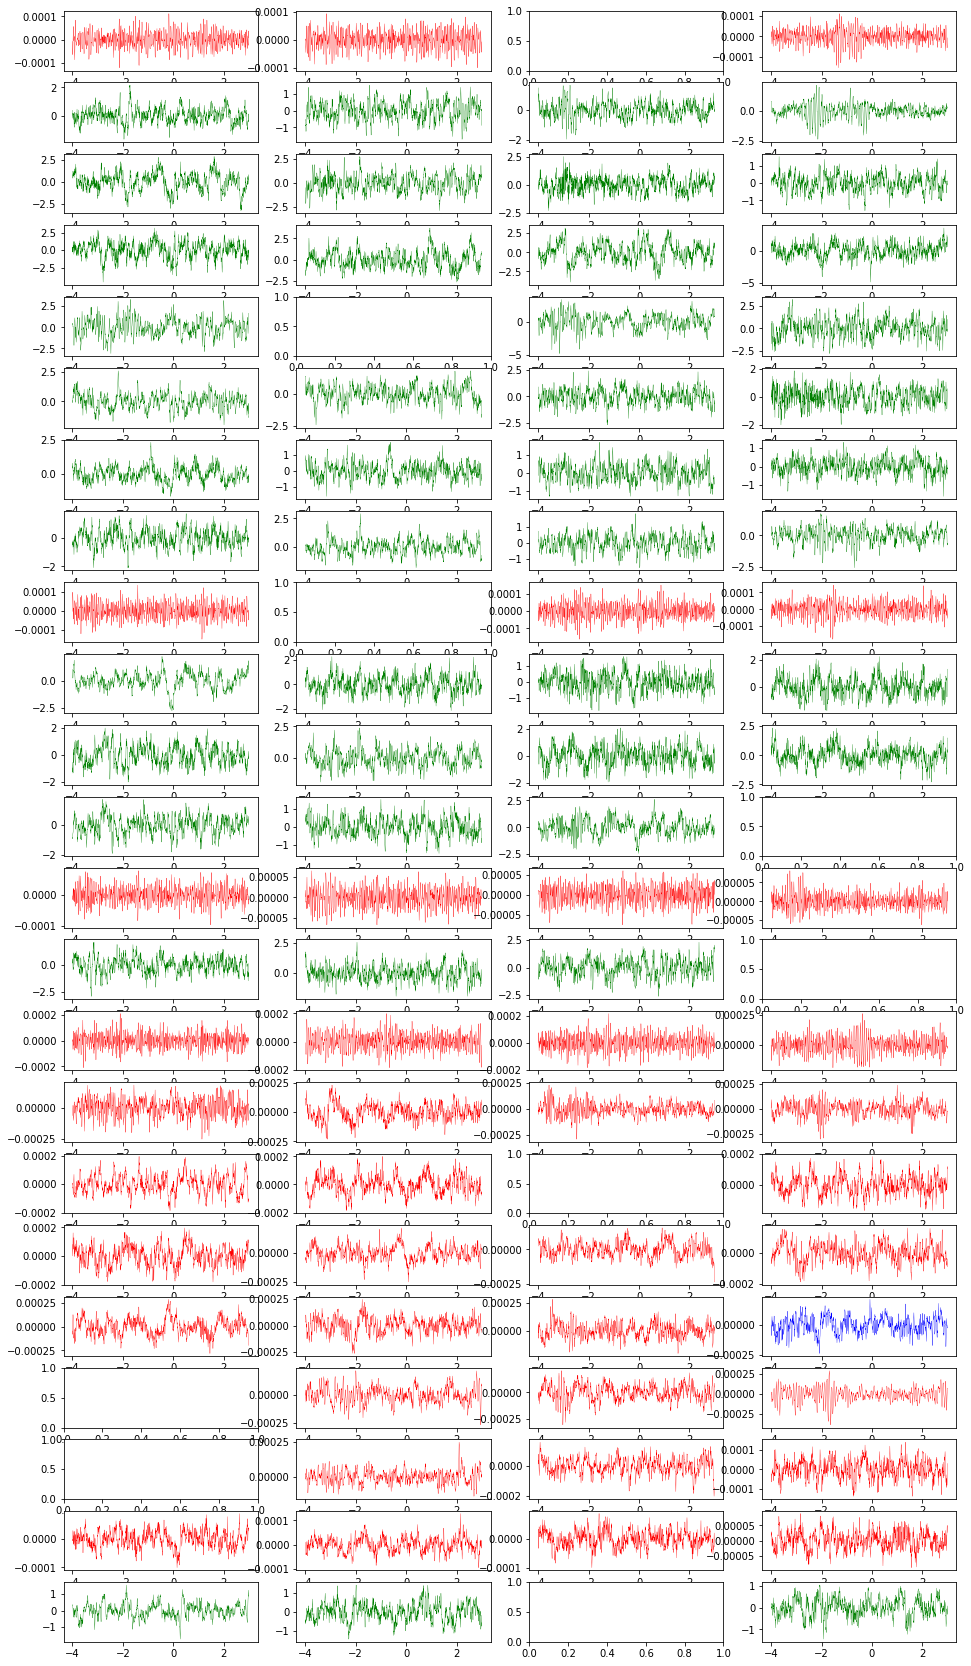

In [25]:
plot_all_timecourses()

# Let's not wait any longer and try to plot a wavelet transform!

In [9]:
# Use MNE to extract TFR
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])
n_cycles = data['freq_axis']/2

In [10]:
def wavelet_transform (subj=1, IC=1, trial=1):
    raw = mne.EpochsArray(data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][trial-1,np.newaxis,np.newaxis,:], info, verbose=False) 
    tfr = mne.time_frequency.tfr_morlet(raw, freqs=data['freq_axis'], n_cycles=n_cycles, picks='eeg', return_itc=False)
    return tfr._data

In [11]:
# For a wavelet transform on several trials/all the trials:

# raw = mne.EpochsArray(raw_timecourse_subj0_IC0[100:105, np.newaxis, :], info, verbose=False) 
# raw = mne.EpochsArray(raw_timecourse_subj0_IC0[:, np.newaxis, :], info, verbose=False) 

In [12]:
# Here we calculate and store in `data` the complete time-frequency data for each 1st trial
def load_all_tfr_one_trial (trial=1):
    for IC in range(1, n_IC+1):
        for subj in range(1, n_subj+1):
            try:
                data[f'tfr_256Hz subject{subj}, IC{IC}, trial{trial}'] = wavelet_transform(subj, IC, trial)
            except:
                pass

load_all_tfr_one_trial()

In [44]:
# def plot_all_tfr_one_trial (trial=1, vmin=None, vmax=None):
#     plt.figure(figsize=(16, 30))
#     plt.title('Wavelet transform')
#     for IC in range(1, n_IC+1):
#         for subj in range(1, n_subj+1):
#             try:
#                 plt.subplot(n_subj, n_IC, IC+(subj-1)*n_IC)
#                 plt.imshow(data[f'tfr_256Hz subject{subj}, IC{IC}, trial{trial}'][0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], vmin=vmin, vmax=vmax, cmap='RdBu_r')
#                 plt.tight_layout()
#                 plt.colorbar()
#             except:
#                 pass
#     plt.savefig('all-tfr_trial1.png', dpi=600)
            
def plot_all_tfr_one_trial (trial=1, vmin=None, vmax=None):
    fig = plt.figure(figsize=(13, 20), clear=True)
    for subj in range(1, n_subj+1):
        for IC in range(1, n_IC+1):
            try:
                plt.subplot(4, 1, IC)
                plt.title(f'Wavelet transform IC{IC}')
                plt.imshow(data[f'tfr_256Hz subject{subj}, IC{IC}, trial{trial}'][0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], vmin=vmin, vmax=vmax, cmap='RdBu_r')
                plt.xlabel('Time (s)')
                plt.ylabel('Frequencies (Hz)')
                plt.colorbar()
            except:
                pass
        plt.savefig(f'tfr/tfr-subj{subj}_trial1.png', dpi=600)
        fig.clf()

# plt.figure(figsize=(13, 5))
# plt.xlabel('Time (s)')
# plt.ylabel('Frequencies (Hz)')
# plt.savefig('tde-hmm.png', dpi=600)

In [45]:
plot_all_tfr_one_trial ()

<Figure size 936x1440 with 0 Axes>

# Now we'll implement the HMM method.

In [175]:
# La fonction embedx copie le vecteur `x` len(lags) fois dans `xe`
# avec des décalages entre lags[0] et lags[-1] (on implémente le délai temporel pour le HMM)

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


# La fonction hmm_tde trouve les paramètres du HMM

def hmm_tde(data: np.array, lags, n_states=3, n_iter=100, n_components=8, covariance_type='full', model_type='GMMHMM', **kwargs):
    
    # Embed time serie
    xe, valid = embedx(data, lags)

    pca = PCA(n_components=n_components)
    y = pca.fit_transform(xe[0, :, :])
    
    if model_type=='GMMHMM':
        model = hmm.GMMHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, **kwargs)
        
    elif model_type=='GaussianHMM':
        model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, **kwargs)
        
    elif model_type=='MultinomialHMM':
        model = hmm.MultinomialHMM(n_components=n_states, n_iter=n_iter, **kwargs)
    
    else: 
        return "Non-exixting model_type. Please choose 'GMMHMM' or 'GaussianHMM' or 'MultinomialHMM'. default='GMMHMM'"
        
    model.fit(y)
    gamma = model.predict_proba(y)
    
    return gamma, model, xe

In [176]:
# The data we want to analyse with the HMM method
subj=1
IC=1
trial=1
x = data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][trial-1, :].reshape(-1, 1)

In [188]:
# The parameters we change to hope for some results
lags = np.arange(-29, 29)
n_iter=1000
n_states=3    # nb d'états du modèle
n_components=8     # nb de composantes principales à extraire
covariance_type='diag'
model_type='GMMHMM'

In [189]:
# Finding the model
gamma, model, xe = hmm_tde(x, lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
                           covariance_type=covariance_type, model_type=model_type)

In [192]:
def plot_hmm_over_tfr(subj, IC, trial):
    plt.figure(figsize=(16, 5))

    plt.subplot(211)
    plt.title('HMM States probability')
    time = data['time_axis'][np.abs(np.min(lags)):-np.abs(np.max(lags))]

    # plot noise state
    burst = np.argmax(np.mean(gamma, 0))
    print(f'burst is state {burst+1}')

    states = np.where([i not in [burst] for i in range(n_states)])[0]
    for i in states:
        plt.fill_between(x=time, y1=gamma[:, i], alpha=0.2)
        plt.xlim(-4, 3)
    plt.plot(time, gamma[:, burst], 'red')
    plt.fill_between(x=time, y1=gamma[:, burst], alpha=0.2, color='red')
    plt.ylabel('State probability')
    
    labels = []
    for i in range(n_states):
        if i!=burst:
            labels.append(f'state {i}')
        else:
            labels.append(f'burst state ({i})')
    plt.legend(labels)

    # Time-frequency plot
    plt.subplot(212)

    plt.title('Wavelet transform')
    plt.imshow(data[f'tfr_256Hz subject{subj}, IC{IC}, trial{trial}'][0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], cmap='RdBu_r')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequencies (Hz)')
    plt.tight_layout()
    plt.savefig(f'tde-hmm/tde-hmm_subj{subj}IC{IC}trial{trial}_{n_states}states_diag.png', dpi=600)

burst is state 2


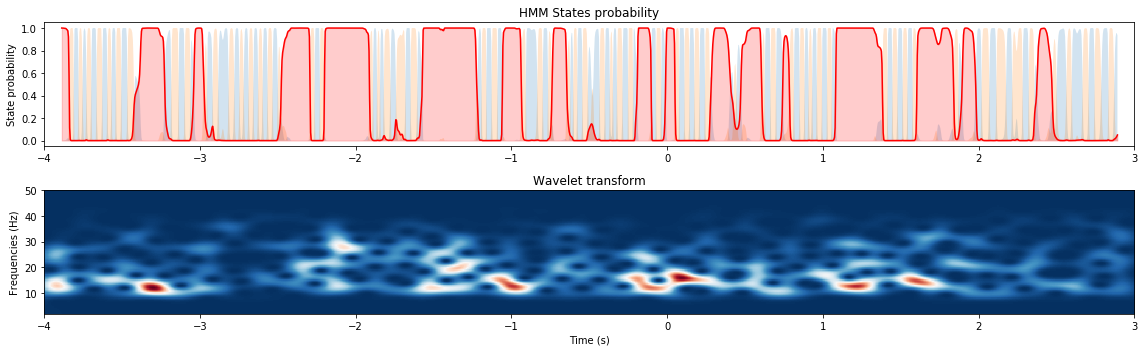

In [193]:
plot_hmm_over_tfr(1, 1, 1)

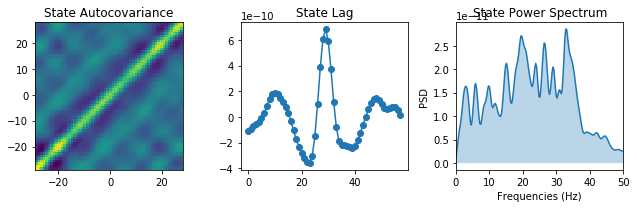

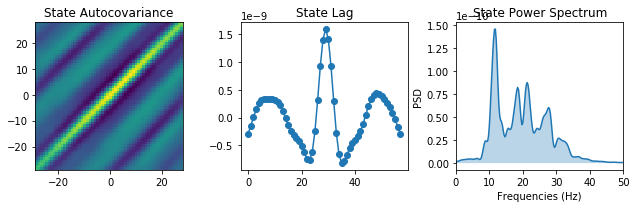

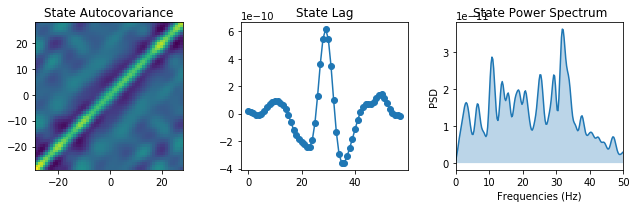

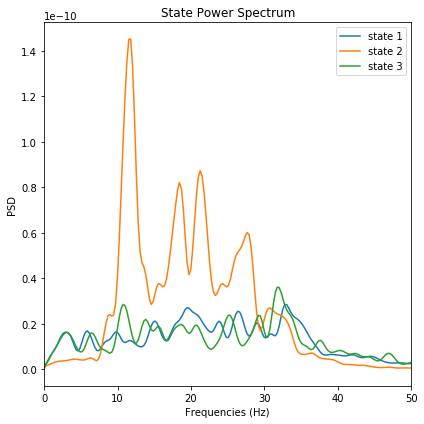

In [194]:
# def show_states():
for i in range(n_states):

    fig = plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.title('State Autocovariance')
    plt.imshow(np.cov(xe[0, gamma[:, i]> .6, :].T), origin='lower', extent=[lags[0], lags[-1], lags[0], lags[-1]])

    plt.subplot(132)
    plt.title('State Lag')
    st_lag = np.cov(xe[0, gamma[:, i]> .6, :].T)[lags[0], :]
    plt.plot(st_lag, 'o-')
    
    plt.subplot(133)
    plt.title('State Power Spectrum')
    
    # Compute PSD separately for each lag
    tot = []
    for seg in xe[0, gamma[:, i]> .6, :].T:
        freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
        tot.append(psd)
    psd = np.mean(np.asarray(tot), 0)
    
    plt.plot(freqs, psd)
    plt.fill_between(x=freqs, y1=psd, alpha=0.3)
    plt.xlim(0, 50)
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.tight_layout()   
    
#     plt.close(fig)

fig = plt.figure(figsize=(6, 6))
plt.title('State Power Spectrum')
for i in range(n_states):
    
    # Compute PSD separately for each lag
    tot = []
    for seg in xe[0, gamma[:, i]> .6, :].T:
        freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
        tot.append(psd)
    psd = np.mean(np.asarray(tot), 0)
    
    plt.plot(freqs, psd)
#     plt.fill_between(x=freqs, y1=psd, alpha=0.3)

plt.xlim(0, 50)
plt.ylabel('PSD')
plt.xlabel('Frequencies (Hz)')
plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
plt.tight_layout()   

plt.savefig(f'tde-hmm/states-info_subj{subj}IC{IC}trial{trial}_{n_states}states_diag.png', dpi=600)
    